In [1]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

%matplotlib inline
import seaborn as sns

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

from tensorflow.keras.callbacks import EarlyStopping

from utilize.data import *
from utilize.transform import *
from utilize.plot import *
from utilize.test import *

Found 60 users data.


# Load Dataset

In [2]:
# Load all the data from Extrasenory dataset
X, y, M, user_index, feature_names, label_names = load_all_data(['1155FF54-63D3-4AB2-9863-8385D0BD0A13', '0A986513-7828-4D53-AA1F-E02D6DF9561B', '7CE37510-56D0-4120-A1CF-0E23351428D2'])

# Dataset Overview

In [3]:
feat_sensor_names = get_sensor_names_from_features(feature_names)
print(pd.unique(feat_sensor_names))

['Acc' 'Gyro' 'Magnet' 'WAcc' 'Compass' 'Loc' 'Aud' 'AP' 'PS' 'LF']


In [4]:
n_examples_per_label = np.sum(np.array(y),axis=0)
labels_and_counts = zip(label_names,n_examples_per_label)
sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1])
print ("number of examples for every context label:")
print ("-"*20)
i = 0
label_x_arr = []
label_y_arr = []
for (label,count) in sorted_labels_and_counts:
    i = i +1
    label_x_arr.append(label)
    label_y_arr.append(count)
    print (" %i : %s - %d minutes"  % (i,label,count))
    pass

number of examples for every context label:
--------------------
 1 : OR_indoors - 3287 minutes
 2 : PHONE_ON_TABLE - 2738 minutes
 3 : SITTING - 2648 minutes
 4 : LYING_DOWN - 2541 minutes
 5 : LOC_home - 2438 minutes
 6 : SLEEPING - 2305 minutes
 7 : AT_SCHOOL - 1396 minutes
 8 : COMPUTER_WORK - 1278 minutes
 9 : PHONE_IN_POCKET - 918 minutes
 10 : OR_standing - 820 minutes
 11 : FIX_walking - 352 minutes
 12 : DRIVE_-_I_M_THE_DRIVER - 280 minutes
 13 : EATING - 141 minutes
 14 : PHONE_IN_HAND - 123 minutes
 15 : CLEANING - 117 minutes
 16 : DRINKING__ALCOHOL_ - 74 minutes
 17 : OR_outside - 73 minutes
 18 : TALKING - 48 minutes
 19 : FIX_restaurant - 33 minutes
 20 : BICYCLING - 27 minutes
 21 : OR_exercise - 27 minutes
 22 : BATHING_-_SHOWER - 20 minutes
 23 : DRESSING - 4 minutes
 24 : COOKING - 3 minutes
 25 : GROOMING - 2 minutes
 26 : FIX_running - 0 minutes
 27 : LAB_WORK - 0 minutes
 28 : IN_CLASS - 0 minutes
 29 : IN_A_MEETING - 0 minutes
 30 : LOC_main_workplace - 0 minutes

<Axes: xlabel='label'>

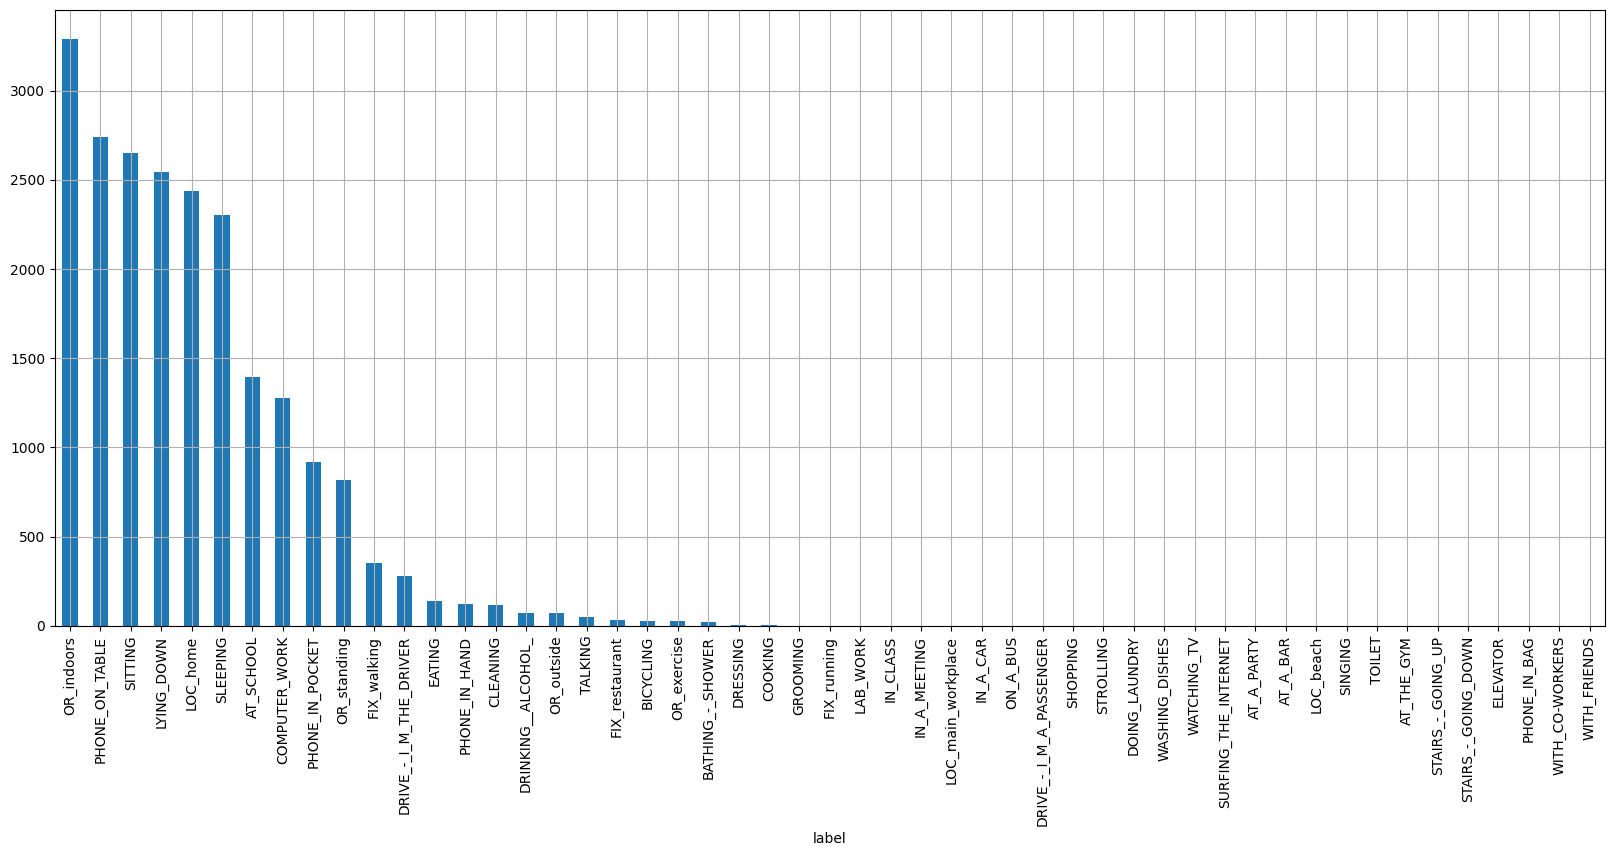

In [5]:
labels_df = pd.DataFrame(sorted_labels_and_counts)
labels_df.rename(columns = {0:'label'}, inplace = True)
labels_df.rename(columns = {1:'count'}, inplace = True)
labels_df.plot(x='label', y='count', kind='bar', legend=False, grid=True, figsize=(20, 8))

# Feature Engineering

In [6]:
time_domain_keywords = ['mean', 'std', 'moment', 'percentile', 'entropy', 'magnitude_stats', '3d']
frequency_domain_keywords = ['spectrum', 'log_energy_band', 'spectral_entropy', 'magnitude_spectrum']

time_domain_columns = [col for col in feature_names if any(keyword in col for keyword in time_domain_keywords)]
frequency_domain_columns = [col for col in feature_names if any(keyword in col for keyword in frequency_domain_keywords)]

# Display the identified columns
print("Time-Domain Columns:")
for col in time_domain_columns:
    print(col)

print("\nFrequency-Domain Columns:")
for col in frequency_domain_columns:
    print(col)

Time-Domain Columns:
raw_acc:magnitude_stats:mean
raw_acc:magnitude_stats:std
raw_acc:magnitude_stats:moment3
raw_acc:magnitude_stats:moment4
raw_acc:magnitude_stats:percentile25
raw_acc:magnitude_stats:percentile50
raw_acc:magnitude_stats:percentile75
raw_acc:magnitude_stats:value_entropy
raw_acc:magnitude_stats:time_entropy
raw_acc:magnitude_spectrum:spectral_entropy
raw_acc:3d:mean_x
raw_acc:3d:mean_y
raw_acc:3d:mean_z
raw_acc:3d:std_x
raw_acc:3d:std_y
raw_acc:3d:std_z
raw_acc:3d:ro_xy
raw_acc:3d:ro_xz
raw_acc:3d:ro_yz
proc_gyro:magnitude_stats:mean
proc_gyro:magnitude_stats:std
proc_gyro:magnitude_stats:moment3
proc_gyro:magnitude_stats:moment4
proc_gyro:magnitude_stats:percentile25
proc_gyro:magnitude_stats:percentile50
proc_gyro:magnitude_stats:percentile75
proc_gyro:magnitude_stats:value_entropy
proc_gyro:magnitude_stats:time_entropy
proc_gyro:magnitude_spectrum:spectral_entropy
proc_gyro:3d:mean_x
proc_gyro:3d:mean_y
proc_gyro:3d:mean_z
proc_gyro:3d:std_x
proc_gyro:3d:std_y
pro

In [7]:
corr_matrix = np.corrcoef(X, rowvar=False)
threshold = 0.95
columns_to_remove = np.where(np.abs(corr_matrix) > threshold)
columns_to_remove = [(i, j) for i, j in zip(columns_to_remove[0], columns_to_remove[1]) if i != j]
dedup_columns = list(set([col[0] for col in columns_to_remove]))
X = np.delete(X, dedup_columns, axis=1)
# X = X[:,dedup_columns]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Data Preprocessing

In [8]:
# Only select body state label
target_labels = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'OR_standing', 'COMPUTER_WORK']
# target_labels = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']
# target_labels = ['LYING_DOWN', 'SITTING', 'FIX_walking']
# Fill the Nan with mean value and normalize all the data 
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('std_scaler', StandardScaler())
])

In [9]:
import warnings
warnings.simplefilter("ignore")

In [10]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM

# RNN Model

In [11]:
def run_rnn_model(X_train, X_test, y_train, y_test, M_train, M_test, y_train_sw1D):
    model = Sequential()
    model.add(Dense(1, input_shape=(X_train.shape[1],), activation="relu"))
    model.add(Dropout(0.2))
    model.compile(loss="binary_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    callback = EarlyStopping(monitor='loss',
                                patience=3)
    model.fit(X_train, y_train,
                        epochs = 20, 
                        batch_size = 5,
                        validation_data = (X_test, y_test),
                        callbacks=[callback],
                        verbose=0,
                        sample_weight = y_train_sw1D)
    # y_pred = model.predict(X_test)
    # print(classification_report(y_test, (y_pred > 0.5).astype(int)))
    accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    return accuracy, precision, recall, f1

# LSTM Model

In [12]:
def run_lstm_model(X_train, X_test, y_train, y_test, M_train, M_test, y_train_sw1D):
    X_train_1 = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_1 = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    model = Sequential()
    model.add(LSTM(1, input_shape=(1, X_train_1.shape[2]), activation="sigmoid"))
    model.add(Dropout(0.2))
    model.compile(loss = "binary_crossentropy",
                optimizer = 'sgd',
                metrics = ['accuracy'])
    callback = EarlyStopping(monitor='loss',
                                patience=3)
    history = model.fit(X_train_1, y_train,
                    epochs = 20, 
                    batch_size = 5,
                    validation_data = (X_test_1, y_test), 
                    callbacks=[callback],
                    verbose=0,
                    sample_weight = y_train_sw1D)
    # Store the performance metric for this split
    accuracy, precision, recall, f1 = evaluate_model(model, X_test_1, y_test)
    return accuracy, precision, recall, f1

# Random Forest Model

In [13]:
def run_random_forest_model(X_train, X_test, y_train, y_test, M_train, M_test, y_train_sw1D):
    rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = 10, min_samples_split = 10)
    rf.fit(X_train, y_train, sample_weight = y_train_sw1D)
    accuracy, precision, recall, f1 = evaluate_model(rf, X_test, y_test)
    return accuracy, precision, recall, f1

# SVM Model

In [14]:
def run_svm_model(X_train, X_test, y_train, y_test, M_train, M_test, y_train_sw1D):
    svm = SVC(kernel='linear', random_state=42)
    history = svm.fit(X_train, y_train, sample_weight = y_train_sw1D)
    # y_pred = svm.predict(X_test)
    accuracy, precision, recall, f1 = evaluate_model(svm, X_test, y_test)
    return accuracy, precision, recall, f1

# Decision Tree Model

In [15]:
from sklearn.tree import DecisionTreeClassifier
def run_decision_tree_model(X_train, X_test, y_train, y_test,M_train, M_test, y_train_sw1D):
    dt = DecisionTreeClassifier(class_weight='balanced', min_samples_split=10)
    dt.fit(X_train, y_train, sample_weight=y_train_sw1D)
    accuracy, precision, recall, f1 = evaluate_model(dt, X_test, y_test)
    return accuracy, precision, recall, f1

In [16]:

run_model = {
    'rnn': run_rnn_model,
    'lstm': run_lstm_model,
    'random_forest': run_random_forest_model,
    'svm': run_svm_model,
    'decision_tree': run_decision_tree_model
}
models = ['rnn', 'lstm', 'random_forest', 'svm', 'decision_tree']



# Cross Validation for Time Series Data

In [17]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


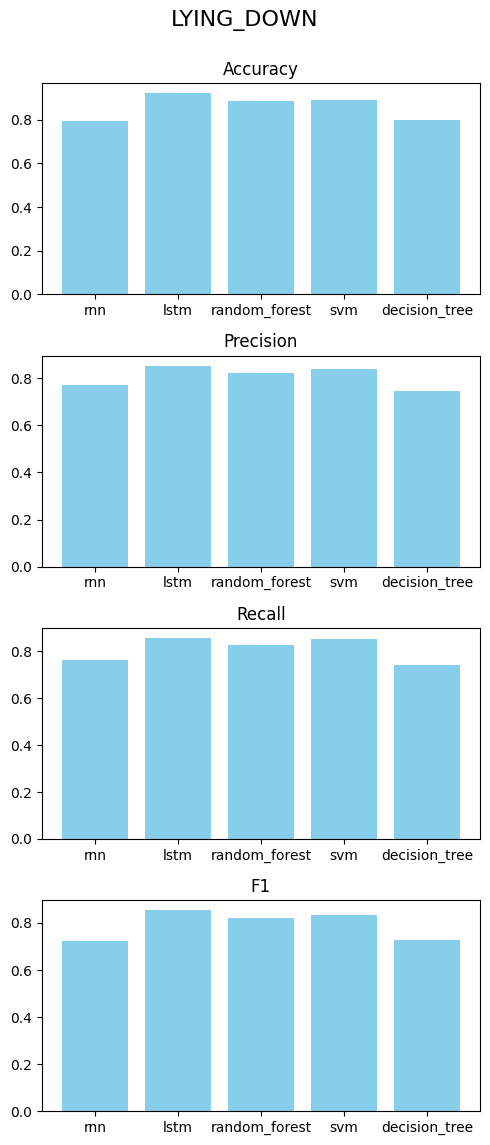

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


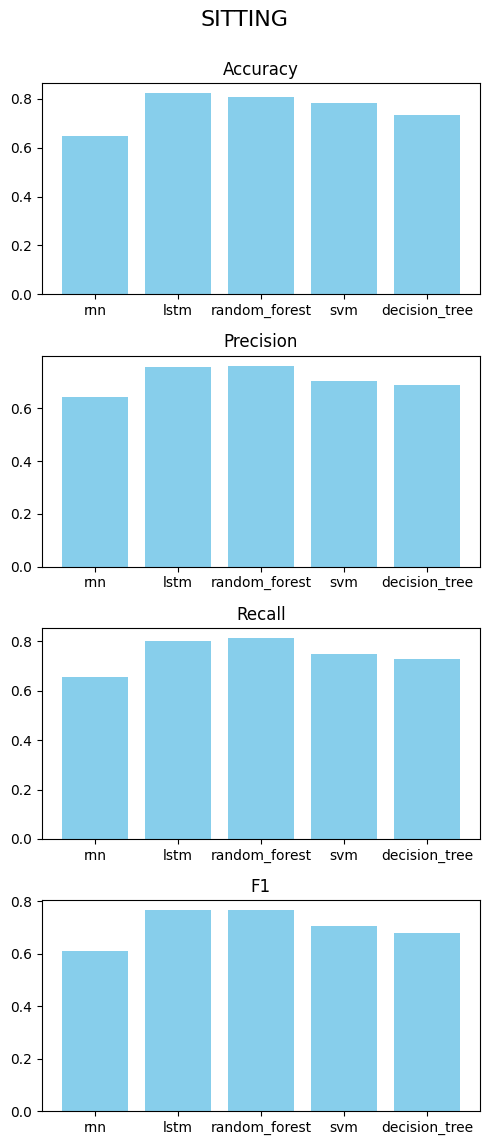

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


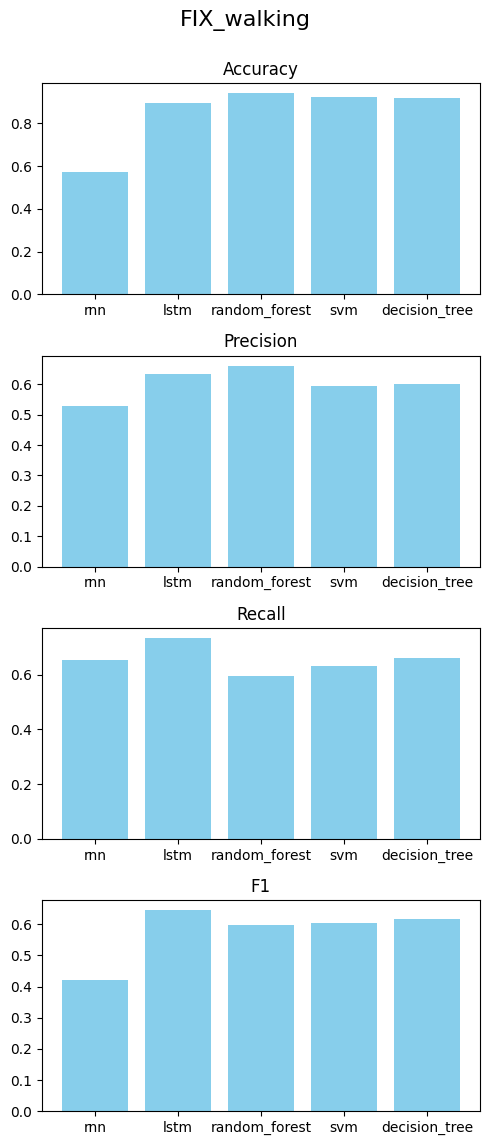

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


ValueError: The number of classes has to be greater than one; got 1 class

In [18]:

for target_label in target_labels:
    accuracy_scores = {}
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}
    X_new, y_new, M_new = select_target_labels(X, y, M, target_label, label_names, drop_all_zero = False)
    X_new = pipeline.fit_transform(X_new, y_new)
    for train_index, test_index in tscv.split(X_new, y_new):
        # Split the data into training and test sets based on the current split indices
        X_train, X_test = X_new[train_index], X_new[test_index]
        y_train, y_test = y_new[train_index], y_new[test_index]
        M_train, M_test = M_new[train_index], M_new[test_index]
        # To swap 0 and 1, simply do 
        y_train_sampleweight = np.abs(1-M_train)
        y_train_sw1D = np.zeros(y_train_sampleweight.shape[0])
        for i in range(len(y_train_sw1D)):
            y_train_sw1D[i] = np.sum(y_train_sampleweight[i])/M_train.shape[1]
        
        for model in models:
            accuracy, precision, recall, f1 = run_model[model](X_train,X_test,y_train,y_test,M_train,M_test,y_train_sw1D)
            accuracy_scores[model] = accuracy_scores[model]+[accuracy] if accuracy_scores.get(model) else [accuracy]
            precision_scores[model] = precision_scores[model]+[precision] if precision_scores.get(model) else [precision]
            recall_scores[model] = recall_scores[model]+[recall] if recall_scores.get(model) else [recall]
            f1_scores[model] = f1_scores[model]+[f1] if f1_scores.get(model) else [f1]
    
    metrics_data = {
        'Accuracy': {key: np.mean(val) for key,val in accuracy_scores.items()},
        'Precision': {key: np.mean(val) for key,val in precision_scores.items()},
        'Recall': {key: np.mean(val) for key,val in recall_scores.items()},
        'F1': {key: np.mean(val) for key,val in f1_scores.items()}
    }
    plot_metric(metrics_data, target_label)
    # plot_metric(models, [np.mean(val) for val in accuracy_scores.values()], f'Accuracy for {target_label}')
    # plot_metric(models, [np.mean(val) for val in precision_scores.values()], f'Precision for {target_label}')
    # plot_metric(models, [np.mean(val) for val in recall_scores.values()], f'Recall for {target_label}')
    # plot_metric(models, [np.mean(val) for val in f1_scores.values()], f'F1 for {target_label}')